In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import glob
import os
import re

%matplotlib inline

In [2]:
cwd = os.getcwd()

SAMPLE_SIZE = 5090
SPLIT_RATIO = 0.7

PADDING_SIZE = 5
IMAGE_SIZE = 256
BATCH_SIZE = 4

In [3]:
index = np.arange(SAMPLE_SIZE) + 1
np.random.seed(1234)
np.random.shuffle(index)

split = (int) (SAMPLE_SIZE * SPLIT_RATIO)
x_train_idx = index[0:split]
x_test_idx = index[split:]

In [4]:
ALL_WORD = ['', 'statement', 'if', 'else', 'elseif', 'for', 'while', 'end', '<START>', '<END>']
N_ONEHOT_WORD = len(ALL_WORD) - 1
CHARS_MAP = {v: k for k, v in enumerate(ALL_WORD)}
IDX_MAP = dict(list(enumerate(ALL_WORD)))

def to_onehot(word):
    n_onehot = N_ONEHOT_WORD
    idx = CHARS_MAP[word]
    if idx == 0:
        return np.zeros(n_onehot)
    else:
        onehot_vec = np.zeros(n_onehot)
        onehot_vec[idx - 1] = 1
        return onehot_vec

def convert_to_feature_list(feature_words):
    onehots = []
    for word in feature_words:
        onehots.append(to_onehot(word))
    return np.array(onehots)
        

def convert_to_input_set(tokens, k):
    n_tokens = len(tokens)
    padded_token = [''] * (k - 1) + ["<START>"] + tokens + ["<END>"]
    res = []
    for i in range(n_tokens + 1):
        res.append((
            convert_to_feature_list(padded_token[i:i + k]),
            to_onehot(padded_token[i + k])
        ))
    return res

def read_image(image_file):
    image = Image.open(image_file).convert('L')
    image = image.convert()
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.asarray(image).reshape((IMAGE_SIZE, IMAGE_SIZE, 1))
    return 1 - (image / 255)

In [5]:
def input_generator(indexs):
    files = glob.glob("./data/*")
    
    while(True):
        x_word = []
        x_image = []
        y = []
        
        for idx in indexs:
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            lang_file = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-lang.txt").search, files))
            
            if len(lang_file) == 0:
                continue
            
            with open(lang_file[0], 'r') as file:
                lang = [l.strip().split(" ")[0] for l in file.read().split("\n") if len(l)]
                lang = list(map(lambda x: "statement" if x.startswith("statement") else x, lang))
            
            embed_lang = convert_to_input_set(lang, PADDING_SIZE)
            
            for picture in picture_files:
                image = read_image(picture)

                for lang in embed_lang:
                    x_word.append(lang[0])
                    x_image.append(image)
                    y.append(lang[1])
                    
                    if len(y) >= BATCH_SIZE:
                        yield [np.array(x_word), np.array(x_image)], np.array(y)
                        x_word = []
                        x_image = []
                        y = []

In [6]:
def test_input_generator():
    count = 0
    for x,y in input_generator(x_train_idx):
        count += 1
        if count > 10:
            break

# test_input_generator()

In [35]:
from keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D, LSTM, RepeatVector, Embedding
from keras.layers import Reshape, UpSampling2D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K

def generate_model():
    word_input = Input(batch_shape=(BATCH_SIZE, PADDING_SIZE, N_ONEHOT_WORD))
    image_input = Input(batch_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu', trainable=False)(image_input)
    
    img = MaxPooling2D()(img)
    img = Conv2D(64, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(92, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(128, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(192, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(224, (3,3), padding='same', activation='relu', trainable=False)(img)
    
    img = Flatten()(img)
    img = Dense(2048, trainable=False)(img)
    img = RepeatVector(PADDING_SIZE)(img)
    
    w = LSTM(512, return_sequences=True, stateful=True)(word_input)
    w = LSTM(512, return_sequences=True, stateful=True)(w)
    
    x = Concatenate()([w, img])
    x = LSTM(512, return_sequences=True, stateful=True)(x)
    x = LSTM(512, stateful=True)(x)
    
    outputs = Dense(N_ONEHOT_WORD, activation='softmax')(x)

    optimizer = Adam(lr=0.0001)
    model = Model(inputs=[word_input, image_input], outputs=outputs)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [36]:
print(generate_model().summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (4, 256, 256, 1)     0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (4, 256, 256, 32)    320         input_31[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (4, 128, 128, 32)    0           conv2d_133[0][0]                 
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (4, 128, 128, 64)    18496       max_pooling2d_81[0][0]           
__________________________________________________________________________________________________
max_poolin

In [37]:
def generate_model_img_v7():
    image_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu')(image_input)
    
    img = MaxPooling2D()(img)
    img = Conv2D(64, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(92, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(128, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(192, (3,3), padding='same', activation='relu')(img)
    
    img = MaxPooling2D()(img)
    img = Conv2D(224, (3,3), padding='same', activation='relu')(img)
    
    img = Flatten()(img)
    img = Dense(2048)(img)
    
    img = Dense(8*8*224)(img)
    img = Reshape((8,8,224))(img)
    
    img = Conv2D(224, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(192, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(128, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(92, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(64, (3,3), padding='same', activation='relu')(img)
    img = UpSampling2D()(img)
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    img = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(img)

    outputs = img

    model = Model(inputs=image_input, outputs=outputs)
    model.compile(optimizer='adadelta',
                  loss='binary_crossentropy')
    
    return model

In [38]:
model = None

def migrate_model():
    global model
    model_img = generate_model_img_v7()
    model_img.load_weights('./model/model-ae-weight-7.hdf5')
    model_img_weights = model_img.get_weights()

    model = generate_model()


    target_layer = list(range(1,12)) + [15]
    origin_layer = list(range(1,12)) + [13]

    for i, t in enumerate(target_layer):
        o = origin_layer[i]
        print(model.layers[t].name + " : " + model_img.layers[o].name)
    #     if (t == 15):
    #         w = model.layers[t].get_weights()
    #         print(w[0].shape, w[1].shape)
    #         w = model_img.layers[o].get_weights()
    #         print(w[0].shape, w[1].shape)
        model.layers[t].set_weights(
            model_img.layers[o].get_weights()
        )
    
    del model_img

migrate_model()

conv2d_152 : conv2d_139
max_pooling2d_91 : max_pooling2d_86
conv2d_153 : conv2d_140
max_pooling2d_92 : max_pooling2d_87
conv2d_154 : conv2d_141
max_pooling2d_93 : max_pooling2d_88
conv2d_155 : conv2d_142
max_pooling2d_94 : max_pooling2d_89
conv2d_156 : conv2d_143
max_pooling2d_95 : max_pooling2d_90
conv2d_157 : conv2d_144
dense_36 : dense_34


In [39]:
from keras.callbacks import Callback

class TensorBoard(Callback):

    def __init__(self, log_dir='./logs',
                 write_graph=False,
                 start_steps=0,
                 batch_freq=1):
        super(TensorBoard, self).__init__()
        
        global tf, projector
        import tensorflow as tf
        from tensorflow.contrib.tensorboard.plugins import projector
        
        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.write_graph = write_graph
        
        self.start_steps = start_steps
        self.steps_counter = 1

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()
        
        self.merged = tf.summary.merge_all()

        if self.write_graph:
            self.writer = tf.summary.FileWriter(self.log_dir,
                                                self.sess.graph)
        else:
            self.writer = tf.summary.FileWriter(self.log_dir)
            
    def save_scalar(self, logs):
        log = logs or {}
        
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(
                summary,
                self.start_steps + self.steps_counter
            )
        self.writer.flush()
            
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_scalar(logs)
        self.steps_counter += 1

    def on_epoch_end(self, epoch, logs=None):
        self.save_scalar(logs)        

    def on_train_end(self, _):
        self.writer.close()

class ModelCheckpoint(Callback):

    def __init__(self,
                 filepath,
                 start_steps=0,
                 batch_freq=1):
        super(ModelCheckpoint, self).__init__()
        
        self.filepath = filepath
        
        self.steps_counter = 0
        self.start_steps = start_steps
        self.batch_freq = batch_freq
        
        self.steps_counter
        
    def save_model(self):
        self.model.save_weights(self.filepath, overwrite=True)
        
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_model()
        self.steps_counter += 1
        
    def on_epoch_end(self, epoch, logs=None):
        self.save_model()

In [40]:
model.fit_generator(
    input_generator(x_train_idx),
    steps_per_epoch=50094,
    validation_data=input_generator(x_test_idx),
    validation_steps=3382,
    max_queue_size=5,
    epochs=3,
    use_multiprocessing=True,
    callbacks=[
        TensorBoard(
            log_dir="./model/logs/",
            batch_freq=5
        ),
        ModelCheckpoint(
            filepath="./model/model-weight-1.hdf5",
            batch_freq=100
        )
    ]
)

Epoch 1/3
    2/50094 [..............................] - ETA: 23:50:08 - loss: 2.1860 - acc: 0.1250

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.028638). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (1.014886). Check your callbacks.
  % delta_t_median)


34441/50094 [===================>..........] - ETA: 25:10 - loss: 0.6681 - acc: 0.7561

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45140/50094 [==========================>...] - ETA: 7:56 - loss: 0.5777 - acc: 0.7885

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50094/50094 [==============================] - 4940s 99ms/step - loss: 0.5464 - acc: 0.8000 - val_loss: 0.4662 - val_acc: 0.8285
Epoch 2/3
50094/50094 [==============================] - 4993s 100ms/step - loss: 0.2125 - acc: 0.9179 - val_loss: 0.2728 - val_acc: 0.8928
Epoch 3/3
50094/50094 [==============================] - 4965s 99ms/step - loss: 0.1528 - acc: 0.9364 - val_loss: 0.2460 - val_acc: 0.9021



942


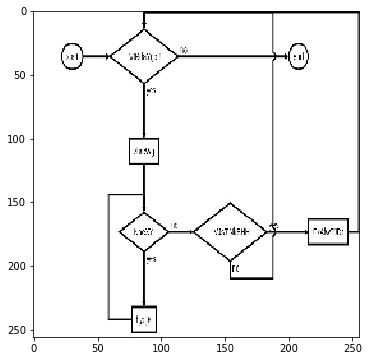

ValueError: Cannot feed value of shape (1, 5, 9) for Tensor 'input_33:0', which has shape '(4, 5, 9)'

In [81]:
def analyze():
    count = 0
    files = glob.glob("./data/*")
    for idx in x_test_idx:
        if count % 5 == 0:
            print("\n===================")
            print(idx)
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            lang_file = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-lang.txt").search, files))

            image = read_image(picture_files[0]).reshape((IMAGE_SIZE, IMAGE_SIZE))

            plt.figure(figsize = (6,6))
            plt.imshow(image, cmap='Greys')
            plt.show()
            
            with open(lang_file[0], 'r') as file:
                lang = [l.strip().split(" ")[0] for l in file.read().split("\n") if len(l)]
                lang = list(map(lambda x: "statement" if x.startswith("statement") else x, lang))
            
            token = [''] * (PADDING_SIZE - 1) + ['<START>']
        
            result = model.predict([
                np.expand_dims(convert_to_feature_list(token), axis=0),
                image.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 1))
            ])
            print(result)
            print(lang)
        count += 1
        if count > 25:
            break
            
# analyze()